<a href="https://colab.research.google.com/github/mikemykhaylov/mat422Coursework/blob/main/3_7_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install numpy seaborn scipy matplotlib ipympl pillow scikit-learn requests sympy torch torchinfo

  Using cached ipympl-0.9.3-py2.py3-none-any.whl (511 kB)
  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)
  Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
%matplotlib widget

# 3.7: Neural Networks

## Topics of this chapter:
- Mathematical foundation
- Activation functions
- Cost functions
- Backpropagation
- Gradient descent

## Mathematical foundation

A layer of a neural network is a function $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$ that takes an input vector $x \in \mathbb{R}^n$ and outputs a vector $f(x) \in \mathbb{R}^m$. A neural network is a composition of layers. For example, a neural network with 3 layers $f_1, f_2, f_3$ is a function $f_3 \circ f_2 \circ f_1: \mathbb{R}^n \rightarrow \mathbb{R}^m$.

In the simplest case of a multilayer perceptron, a single layer can be represented as matrix multiplication followed by a non-linear function. For example, a layer with 3 inputs and 2 outputs can be represented as:

$$
f(x) = \sigma(Wx + b)
$$

where $W$ is a $2 \times 3$ matrix, $b$ is a $2$-dimensional vector, and $\sigma$ is a non-linear function applied element-wise to the vector $Wx + b$. The matrix $W$ and the vector $b$ are called the weights and biases of the layer, respectively.

## Activation functions

The activation function $\sigma$ is a non-linear function applied element-wise to the vector $Wx + b$. The most common activation functions are:

- Sigmoid: $\sigma(x) = \frac{1}{1 + e^{-x}}$
- Tanh: $\sigma(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
- ReLU: $\sigma(x) = \max(0, x)$

## Cost functions

The cost function is a function that measures how well the neural network is performing. The goal of training a neural network is to minimize the cost function. The most common cost functions are:

- Mean squared error (for regression): $C(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$
- Cross-entropy (for classification): $C(y, \hat{y}) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$
- Hinge loss (for classification): $C(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^n \max(0, 1 - y_i \hat{y}_i)$

## Backpropagation

Backpropagation is an algorithm for computing the gradient of the cost function with respect to the weights and biases of the neural network. The gradient is then used to update the weights and biases using gradient descent.

## Gradient descent

Gradient descent is an algorithm for minimizing a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ by taking steps proportional to the negative of the gradient of $f$ at the current point. The gradient descent update rule is:

$$
x_{t+1} = x_t - \alpha \nabla f(x_t)
$$

where $x_t$ is the current point, $\alpha$ is the learning rate, and $\nabla f(x_t)$ is the gradient of $f$ at $x_t$.

In [4]:
# load the cali housing dataset for demonstration
from sklearn.datasets import fetch_california_housing

# load the dataset
cali = fetch_california_housing()

# split the dataset into training and testing sets

from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(cali.data, cali.target)

# convert y shape to 2D
y_train_full = y_train_full.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# print dimensions of all the sets
print("X_train_full.shape: ", X_train_full.shape)
print("y_train_full.shape: ", y_train_full.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train_full.shape:  (15480, 8)
y_train_full.shape:  (15480, 1)
X_test.shape:  (5160, 8)
y_test.shape:  (5160, 1)


In [5]:
# create the neural network model

import torch
from torch import nn

# use the GPU if available to speed up training
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )

    def forward(self, X):
        return self.model(X)

model = NeuralNetwork().to(device)

In [6]:
# print model summary
from torchinfo import summary

summary(model, input_size=(1, 8), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 30]                   270
│    └─ReLU: 2-2                         [1, 30]                   --
│    └─Linear: 2-3                       [1, 1]                    31
Total params: 301
Trainable params: 301
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [7]:
# define the loss function and optimizer
from torch import optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [8]:
# define data loaders

batch_size = 32

from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(torch.tensor(X_train_full, dtype=torch.float32), torch.tensor(y_train_full, dtype=torch.float32))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_dl = DataLoader(test_ds, batch_size=batch_size)

for X, y in train_dl:
    print("X.shape: ", X.shape)
    print("y.shape: ", y.shape)
    break

X.shape:  torch.Size([32, 8])
y.shape:  torch.Size([32, 1])


In [9]:
# define training and testing functions

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    test(test_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 61032.667969 [    0/15480]
loss: 219.269272 [ 3200/15480]
loss: 5.036469 [ 6400/15480]
loss: 7.643190 [ 9600/15480]
loss: 3.942943 [12800/15480]
Test Error: 
 Avg loss: 3.519306 

Epoch 2
-------------------------------
loss: 2.171185 [    0/15480]
loss: 4.328579 [ 3200/15480]
loss: 2.806956 [ 6400/15480]
loss: 3.479487 [ 9600/15480]
loss: 1.485518 [12800/15480]
Test Error: 
 Avg loss: 1.763792 

Epoch 3
-------------------------------
loss: 2.202427 [    0/15480]
loss: 2.203902 [ 3200/15480]
loss: 1.284094 [ 6400/15480]
loss: 1.311592 [ 9600/15480]
loss: 1.596268 [12800/15480]
Test Error: 
 Avg loss: 1.159746 

Epoch 4
-------------------------------
loss: 1.426768 [    0/15480]
loss: 1.285264 [ 3200/15480]
loss: 1.500291 [ 6400/15480]
loss: 0.765361 [ 9600/15480]
loss: 0.816892 [12800/15480]
Test Error: 
 Avg loss: 0.961939 

Epoch 5
-------------------------------
loss: 0.833000 [    0/15480]
loss: 1.330242 [ 3200/15480]
loss: 0.775744 [

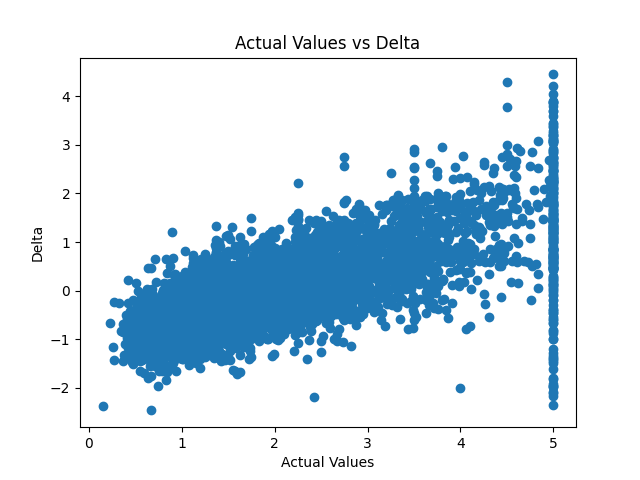

In [12]:
# plot the test dataset actual values on x-axis and delta between actual and predicted values on y-axis
import numpy as np

model.eval()

with torch.no_grad():
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    y_pred = model(X_test).cpu().numpy()

y_delta = y_test.cpu().numpy() - y_pred

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test.cpu().numpy(), y_delta)
plt.xlabel("Actual Values")
plt.ylabel("Delta")
plt.title("Actual Values vs Delta")
plt.show()